In [1]:
import os
import urllib

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac
import pystac_client
import shapely
import stackstac
import torchdata
import xarray as xr
import zen3geo

from torch.utils.data import (  # allows us to load data in batches with multiple workers
    DataLoader,
)

In [2]:
auth = earthaccess.login(persist=True)  # persist EDL login to netrc file

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 07/09/2023
Using .netrc file for EDL


Rieche 2018 Fiji Lolol Pine Study Area

https://www.mdpi.com/2072-4292/7/5/4973

In [9]:
from pyproj import Transformer

latitude = -17.578799
longitude = 177.580173

def latlon_to_utm_zone(latitude, longitude):
    zone_number = int((longitude + 180) / 6) + 1
    if latitude < 0:
        hemisphere = 'S'
        epsg_code = 32700 + zone_number
    else:
        hemisphere = 'N'
        epsg_code = 32600 + zone_number
    return zone_number, hemisphere, epsg_code


def latlon_to_utm(lat, lon, epsg_code):
    transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_code}")
    x, y = transformer.transform(lat, lon)
    return x, y

def create_bbox(x, y, buffer_size):
    x1 = x - buffer_size
    y1 = y - buffer_size
    x2 = x + buffer_size
    y2 = y + buffer_size
    return x1, y1, x2, y2


utm_zone, hemisphere, epsg_code = latlon_to_utm_zone(latitude, longitude)
x, y = latlon_to_utm(latitude, longitude, epsg_code)
buffer_size = 5000  # Change this value to adjust the size of the bounding box
bbox_utm = create_bbox(x, y, buffer_size)

def bbox_to_latlon(epsg_code, x1, y1, x2, y2):
    transformer = Transformer.from_crs(f"EPSG:{epsg_code}", "EPSG:4326", always_xy=True)
    lat1, lon1 = transformer.transform(x1, y1)
    lat2, lon2 = transformer.transform(x2, y2)
    return lat1, lon1, lat2, lon2

bbox_latlon = bbox_to_latlon(epsg_code, *bbox_utm)



In [54]:
epsg_code

32760

In [10]:
bbox_utm

(556563.6617724127, 8051319.356579559, 566563.6617724127, 8061319.356579559)

In [11]:
bbox_latlon

(177.53318739403863,
 -17.624124671781825,
 177.62713520313537,
 -17.53346265302712)

We select a time range that works for Sentinel-2, post July 2015.

The dates for the original study used Landsat and looked at January 2005-December 2007 for the training period and January 2008 - September 2010 for the Validation period.

In [67]:
time_range = ["2021-01-01T00:00:00Z", "2023-05-10T23:59:59Z"]
collection_ids = ["HLSL30.v2.0", "HLSS30.v2.0"]  # Harmonized Landsat-8 Sentinel-2 (HLS)

In [74]:
def get_all_items(item_search) -> pystac.ItemCollection:
    return item_search.items()

def cloud_cover_filter(item: pystac.Item, threshold=15) -> bool:
    """
    Return True if less than or equal to 20% cloud cover, else False.
    """
    return item.properties["eo:cloud_cover"] <= threshold

def construct_dp(time_range, collection_id, bbox_latlon):
    query = dict(bbox=list(bbox_latlon), datetime=time_range, collections=[collection_id])
    dp = torchdata.datapipes.iter.IterableWrapper(iterable=[query])
    dp_pystac_client = dp.search_for_pystac_item(
        catalog_url="https://cmr.earthdata.nasa.gov/stac/LPCLOUD",
    )
    dp_hls_items = dp_pystac_client.flatmap(fn=get_all_items)
    dp_hls_filtered = dp_hls_items.filter(filter_fn=cloud_cover_filter)
    return dp_hls_filtered

In [75]:
l30_dp = construct_dp(time_range, "HLSL30.v2.0", bbox_latlon)
s30_dp = construct_dp(time_range, "HLSS30.v2.0", bbox_latlon)
next(iter(l30_dp))

id: HLS.L30.T60KWF.2021169T221239.v2.0
"bbox: [176.999811, -18.176925, 178.037209, -17.181809]"
eo:cloud_cover: 6
datetime: 2021-06-18T22:12:39.694Z
start_datetime: 2021-06-18T22:12:39.694Z
end_datetime: 2021-06-18T22:13:03.627Z
https://stac-extensions.github.io/eo/v1.0.0/schema.json
href: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T60KWF.2021169T221239.v2.0/HLS.L30.T60KWF.2021169T221239.v2.0.VZA.tif
title: Download HLS.L30.T60KWF.2021169T221239.v2.0.VZA.tif
owner: HLS.L30.T60KWF.2021169T221239.v2.0
href: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T60KWF.2021169T221239.v2.0/HLS.L30.T60KWF.2021169T221239.v2.0.B09.tif


In [76]:
gdal_env = stackstac.DEFAULT_GDAL_ENV.updated(
    always=dict(
        GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
        GDAL_HTTP_MERGE_CONSECUTIVE_RANGES="YES",
        GDAL_HTTP_COOKIEFILE=os.path.expanduser("~/cookies.txt"),
        GDAL_HTTP_COOKIEJAR=os.path.expanduser("~/cookies.txt"),
    )
)
l30_hls_stack_dp = l30_dp.stack_stac_items(
    assets=["B05", "B04", "B03"],  # NIRRG bands
    epsg=epsg_code,  # UTM Zone 11N
    resolution=30,  # Spatial resolution of 30 metres
    bounds_latlon=bbox_latlon,
    xy_coords="center",  # pixel centroid coords instead of topleft corner
    dtype=np.float16,  # Use a lightweight data type
    # https://github.com/gjoseph92/stackstac/issues/133
    gdal_env=gdal_env,
)

s30_hls_stack_dp = s30_dp.stack_stac_items(
    assets=["B08", "B04", "B03"],  # NIRRG bands
    epsg=epsg_code,  # UTM Zone 11N
    resolution=30,  # Spatial resolution of 30 metres
    bounds_latlon=bbox_latlon,
    xy_coords="center",  # pixel centroid coords instead of topleft corner
    dtype=np.float16,  # Use a lightweight data type
    # https://github.com/gjoseph92/stackstac/issues/133
    gdal_env=gdal_env,
)

l30_hls_stack_dp

StackSTACStackerIterDataPipe

In [77]:
it = iter(l30_hls_stack_dp)
dataarray = next(it)
print(dataarray)

<xarray.DataArray 'stackstac-ebc4b5584598f29d7bd89d9a5ca063a1' (time: 1,
                                                                band: 3,
                                                                y: 336, x: 334)>
dask.array<fetch_raster_window, shape=(1, 3, 336, 334), dtype=float16, chunksize=(1, 1, 336, 334), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2021-06-18T22:12:39.694000
    id              (time) <U34 'HLS.L30.T60KWF.2021169T221239.v2.0'
  * band            (band) <U3 'B05' 'B04' 'B03'
  * x               (x) float64 5.566e+05 5.566e+05 ... 5.665e+05 5.666e+05
  * y               (y) float64 8.061e+06 8.061e+06 ... 8.051e+06 8.051e+06
    end_datetime    <U24 '2021-06-18T22:13:03.627Z'
    eo:cloud_cover  int64 6
    start_datetime  <U24 '2021-06-18T22:12:39.694Z'
    title           (band) <U51 'Download HLS.L30.T60KWF.2021169T221239.v2.0....
    epsg            int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, 

/home/work/mambaforge/envs/pybayts/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


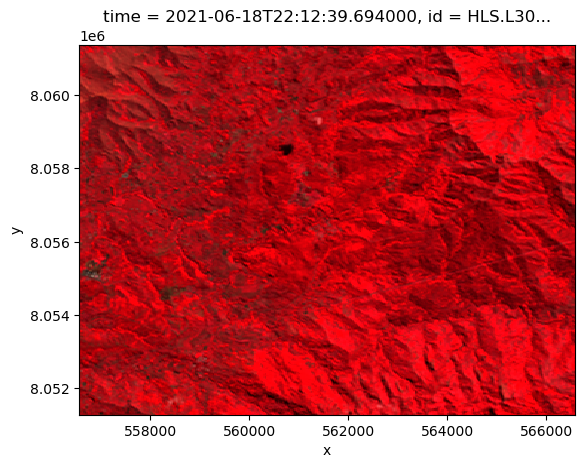

In [78]:
dataarray.isel(time=0).plot.imshow(rgb="band", robust=True)

stacking the arrays

In [79]:
import xarray as xr

# Concatenate along the 'time' dimension
combined = xr.concat(iter(l30_hls_stack_dp), dim='time')

# Rename 'time' to 'date'
combined = combined.rename({'time': 'date'})

# Sort by 'date'
combined = combined.sortby('date')


/home/work/mambaforge/envs/pybayts/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/home/work/mambaforge/envs/pybayts/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/home/work/mambaforge/envs/pybayts/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see 

Still need to compute ndvi

In [81]:
combined

<xarray.DataArray 'stackstac-80abe037d0f0ee4679459ac896316d13' (date: 11,
                                                                band: 3,
                                                                y: 336, x: 334)>
dask.array<concatenate, shape=(11, 3, 336, 334), dtype=float16, chunksize=(1, 1, 336, 334), chunktype=numpy.ndarray>
Coordinates:
  * date            (date) datetime64[ns] 2021-06-18T22:12:39.694000 ... 2022...
    id              (date) <U34 'HLS.L30.T60KWF.2021169T221239.v2.0' ... 'HLS...
  * band            (band) <U3 'B05' 'B04' 'B03'
  * x               (x) float64 5.566e+05 5.566e+05 ... 5.665e+05 5.666e+05
  * y               (y) float64 8.061e+06 8.061e+06 ... 8.051e+06 8.051e+06
    end_datetime    (date) <U24 '2021-06-18T22:13:03.627Z' ... '2022-11-20T22...
    eo:cloud_cover  (date) int64 6 4 13 11 2 7 5 12 4 9 14
    start_datetime  (date) <U24 '2021-06-18T22:12:39.694Z' ... '2022-11-20T22...
    title           (date, band) <U51 'Download HLS.L30.T60KWF.2021169T221239...
    epsg            int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(556560, 8051280, 566580, 8061...
    crs:         epsg:32760
    transform:   | 30.00, 0.00, 556560.00|\n| 0.00,-30.00, 8061360.00|\n| 0.0...
    resolution:  30

In [ ]:
torchdata.datapipes.utils.to_graph(dp=dp_hls_stack)

In [59]:
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rx

from pybayts.bayts import bayts_da_to_date_array
from pybayts.bayts import create_bayts_ts
from pybayts.bayts import deseason_ts
from pybayts.bayts import loop_bayts_update
from pybayts.bayts import merge_cpnf_tseries
from pybayts.data.io import read_and_stack_example_tifs


vv_folder = "../tests/baytsdata/s1vv_tseries/"
ndvi_folder = "../tests/baytsdata/lndvi_tseries/"
pdf_type_l = ("gaussian", "gaussian")
chi = .9
cpnf_min = .5
pdf_forest_l = (0, 0.1)  # mean and sd
pdf_nonforest_l = (-0.5, 0.125)  # mean and sd
bwf_l = (0.1, 0.9)
pdf_type_s = ("gaussian", "gaussian")
pdf_forest_s = (-1, 0.75)  # mean and sd
pdf_nonforest_s = (-4, 1)  # mean and sd
bwf_s = (0.1, 0.9)


In [ ]:

latitude = -17.32
longitude = 177.37
utm_zone = 60
x, y = latlon_to_utm(latitude, longitude, epsg_code)
print(x, y)


In [60]:

s1vv_ts = read_and_stack_example_tifs(vv_folder, ds="vv")
s1vv_ts.name = "s1vv"

lndvi_ts = read_and_stack_example_tifs(ndvi_folder, ds="lndvi")
lndvi_ts.name = "lndvi"

In [63]:
s1vv_ts

<xarray.DataArray 's1vv' (date: 22, y: 100, x: 100)>
array([[[        nan,         nan,         nan, ..., -10.563715 ,
         -10.046777 , -10.30729  ],
        [        nan,         nan,         nan, ..., -11.743282 ,
         -10.887158 , -10.828259 ],
        [        nan,         nan,         nan, ..., -11.671334 ,
         -11.2533045, -11.842816 ],
        ...,
        [ -8.199318 ,  -8.302338 ,  -8.234845 , ...,         nan,
                 nan,         nan],
        [ -8.4950485,  -8.2161045,  -7.82252  , ...,         nan,
                 nan,         nan],
        [ -9.245316 ,  -8.350757 ,  -7.639241 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -10.753237 ,
         -10.938887 , -10.845702 ],
        [        nan,         nan,         nan, ..., -11.451087 ,
         -11.719716 , -11.8533   ],
        [        nan,         nan,         nan, ..., -11.058224 ,
         -11.891154 , -12.622125 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  -9.985711 ,
          -9.265433 ,  -9.427161 ],
        [        nan,         nan,         nan, ..., -11.090907 ,
         -10.073436 ,  -9.886263 ],
        [        nan,         nan,         nan, ..., -11.041241 ,
         -10.292941 , -10.688217 ],
        ...,
        [ -9.422924 ,  -9.595851 ,  -9.027333 , ...,         nan,
                 nan,         nan],
        [ -9.415617 ,  -9.356979 ,  -8.686569 , ...,         nan,
                 nan,         nan],
        [ -9.545348 ,  -9.009067 ,  -8.27215  , ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 5.946e+05 5.946e+05 ... 5.975e+05 5.975e+05
  * y            (y) float64 8.003e+06 8.003e+06 8.003e+06 ... 8e+06 8e+06 8e+06
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2015-12-30 2016-01-05 ... 2016-05-17
    name         (date) <U19 '2015-12-30-s1vv.tif' ... '2016-05-17-s1vv.tif'
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  -6.3344521522522
    STATISTICS_MEAN:     -8.9458994465516
    STATISTICS_MINIMUM:  -12.710973739624
    STATISTICS_STDDEV:   1.173239007311
    scale_factor:        1.0
    add_offset:          0.0